In [37]:
# Import the necessary libraries
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
list_of_class1 = os.listdir("malaria/Parasitized")
list_of_class0 = os.listdir("malaria/Uninfected")

labels1 = np.ones(len(list_of_class1))
labels0 = np.zeros(len(list_of_class0))
labels = np.concatenate((labels1, labels0), axis=0)

dataset = []
dim = (100, 100)
for img in list_of_class1:
  image = cv2.imread("malaria/Parasitized/" + str(img))
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)

for img in list_of_class0:
  image = cv2.imread("malaria/Uninfected/" + str(img))
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)

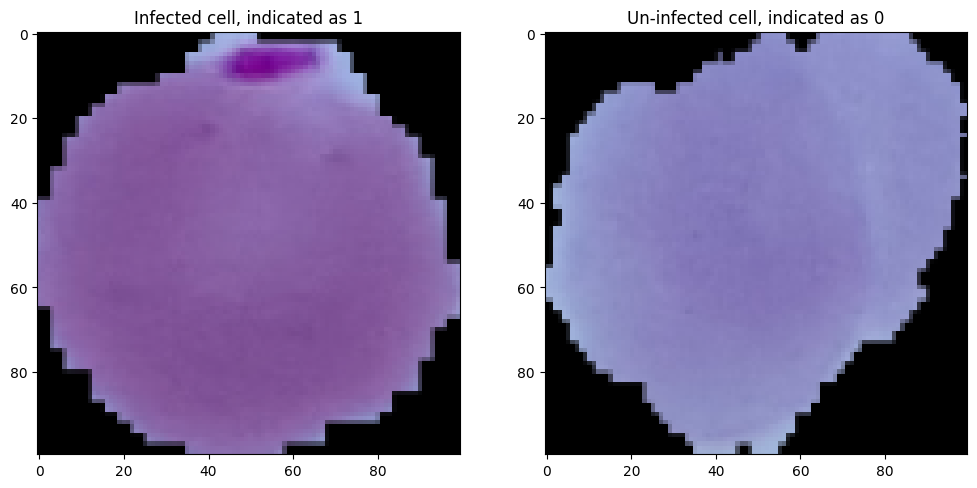

In [39]:
# Visualize the data so we can see what we are working with.
img_infected = cv2.imread('malaria/Parasitized/C39P4thinF_original_IMG_20150622_105335_cell_21.png')
img_uninfected = cv2.imread('malaria/Uninfected/C1_thinF_IMG_20150604_104919_cell_84.png')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.set_title("Infected cell, indicated as 1")
ax1.imshow(dataset[0])
ax2.set_title("Un-infected cell, indicated as 0")
ax2.imshow(dataset[-1])

In [40]:
dataset = np.array(dataset)
labels = np.array(labels)

n = np.arange(dataset.shape[0])
np.random.shuffle(n)

dataset = dataset[n]
labels = labels[n]

dataset = dataset.astype(np.float32)
labels = labels.astype(np.int32)
dataset = dataset/255

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("", X_train.shape, "\n", y_train.shape, 
      "\n", X_val.shape, "\n", y_val.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (700, 100, 100, 3) 
 (700,) 
 (150, 100, 100, 3) 
 (150,) 
 (150, 100, 100, 3) 
 (150,)


In [42]:
# Create the model
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape = (100, 100, 3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 49, 49, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 23, 23, 32)       

In [43]:
# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=3)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [44]:
history = model.fit(X_train, y_train,
                    steps_per_epoch = len(X_train),
                    epochs = 20,
                    validation_data = (X_val,y_val),
                    validation_steps = len(X_val))

Epoch 1/30


2022-11-25 19:15:28.715564: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 84000000 exceeds 10% of free system memory.


700/700 [==============================] - 10s 13ms/step - loss: 0.7578 - accuracy: 0.5243 - val_loss: 0.6895 - val_accuracy: 0.5267
Epoch 2/30
700/700 [==============================] - 9s 13ms/step - loss: 0.6709 - accuracy: 0.5743 - val_loss: 0.6849 - val_accuracy: 0.4933
Epoch 3/30
700/700 [==============================] - 9s 13ms/step - loss: 0.6639 - accuracy: 0.5929 - val_loss: 0.6815 - val_accuracy: 0.5600
Epoch 4/30
700/700 [==============================] - 9s 13ms/step - loss: 0.6540 - accuracy: 0.6414 - val_loss: 0.6825 - val_accuracy: 0.5733
Epoch 5/30
700/700 [==============================] - 9s 13ms/step - loss: 0.5936 - accuracy: 0.6757 - val_loss: 0.7220 - val_accuracy: 0.5267
Epoch 6/30
700/700 [==============================] - 9s 13ms/step - loss: 0.5560 - accuracy: 0.7171 - val_loss: 0.6765 - val_accuracy: 0.5800
Epoch 7/30
700/700 [==============================] - 9s 13ms/step - loss: 0.5023 - accuracy: 0.7557 - val_loss: 0.6549 - val_accuracy: 0.6200
Epoch 8/3

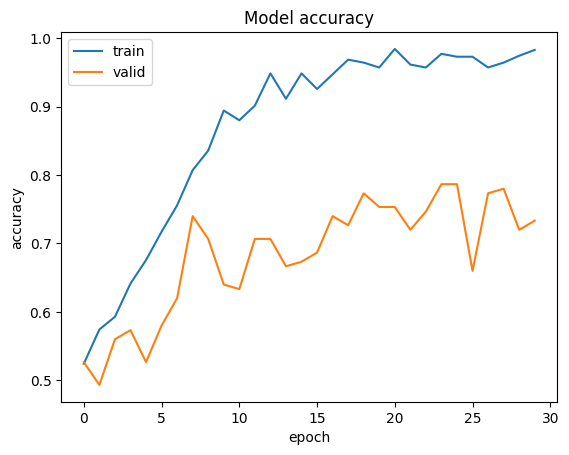

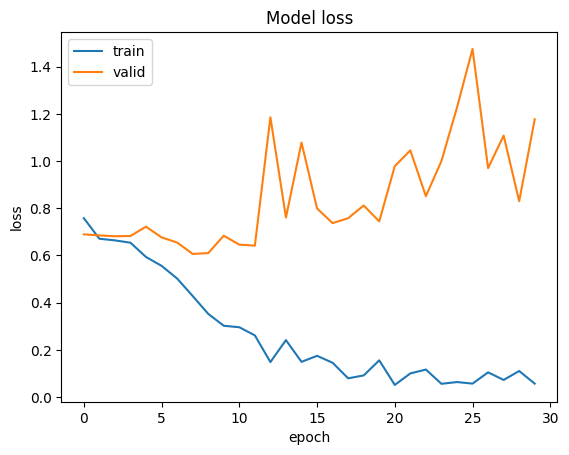

In [46]:
from matplotlib import pyplot as plt

def display_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history);

In [47]:
(model_loss, model_accuracy) = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 18ms/step - loss: 1.2760 - accuracy: 0.7400
